This code uses features extracted using ResNet50 for all the images in the dataset. On the features, PCA is applied to perform dimensionality reduction and finally KNN is used to return the Top N recommended products.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import time
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
import plotly.express as px
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow_datasets as tfds
import keras
from scipy import spatial
from keras import layers
from keras.preprocessing import image
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from keras.preprocessing import image
tfkl = tfk.layers

The file emb_matrix.csv has the 2048 features obtained for all the images in the dataset using ResNet50.

In [43]:
emb = pd.read_csv("/kaggle/input/resnet50-emb/emb_matrix.csv")

In [44]:
emb.head()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,11.467101,24.375347,2.394572,5.675438,10.293070,4.396041,15.002939,7.942683,3.122722,9.764480,...,4.526309,8.806231,10.167510,12.207253,11.108115,3.917942,11.812906,8.912256,7.527889,21.203213
1,11.360403,28.873011,6.209032,4.508435,10.942026,9.140931,19.895555,11.455869,3.406259,4.944487,...,8.047299,7.447005,11.673160,5.906898,6.890153,3.207030,8.099847,7.459054,6.093646,26.040031
2,6.315001,18.561722,1.157191,1.423485,21.873127,4.470167,15.399438,16.044966,6.415497,6.616863,...,3.242900,7.784538,7.018058,7.973488,8.528345,4.429887,14.573654,5.060492,13.813715,11.160487
3,15.669891,18.728531,7.941226,6.822183,11.345028,7.277330,17.457182,10.186830,2.913542,5.126184,...,11.268384,9.369695,7.440072,5.530585,15.117517,11.030376,9.127235,15.141878,7.827703,9.321061
4,14.826392,15.778180,5.702676,7.882212,15.539780,6.508905,19.649069,15.052256,3.271335,7.763330,...,7.718398,11.015994,10.826401,9.204471,20.001060,2.589969,5.004478,14.578427,9.850271,23.341358


In [45]:
filename_ids = pd.read_csv("/kaggle/input/file-name-id/file_name_id.csv")

In [46]:
filename_ids.head()

,filename,id
0,../input/fashion-product-images-dataset/fashio...,15970
1,../input/fashion-product-images-dataset/fashio...,39386
2,../input/fashion-product-images-dataset/fashio...,59263
3,../input/fashion-product-images-dataset/fashio...,21379
4,../input/fashion-product-images-dataset/fashio...,53759


In the following part, the features of each image is concatenated with it's name and Id.

In [47]:
emb_with_ids = pd.concat([emb, filename_ids], axis = 1, ignore_index=False)

In [48]:
emb_with_ids.head()

,0,1,2,3,4,5,6,7,8,9,...,2040,2041,2042,2043,2044,2045,2046,2047,filename,id
0,11.467101,24.375347,2.394572,5.675438,10.293070,4.396041,15.002939,7.942683,3.122722,9.764480,...,10.167510,12.207253,11.108115,3.917942,11.812906,8.912256,7.527889,21.203213,../input/fashion-product-images-dataset/fashio...,15970
1,11.360403,28.873011,6.209032,4.508435,10.942026,9.140931,19.895555,11.455869,3.406259,4.944487,...,11.673160,5.906898,6.890153,3.207030,8.099847,7.459054,6.093646,26.040031,../input/fashion-product-images-dataset/fashio...,39386
2,6.315001,18.561722,1.157191,1.423485,21.873127,4.470167,15.399438,16.044966,6.415497,6.616863,...,7.018058,7.973488,8.528345,4.429887,14.573654,5.060492,13.813715,11.160487,../input/fashion-product-images-dataset/fashio...,59263
3,15.669891,18.728531,7.941226,6.822183,11.345028,7.277330,17.457182,10.186830,2.913542,5.126184,...,7.440072,5.530585,15.117517,11.030376,9.127235,15.141878,7.827703,9.321061,../input/fashion-product-images-dataset/fashio...,21379
4,14.826392,15.778180,5.702676,7.882212,15.539780,6.508905,19.649069,15.052256,3.271335,7.763330,...,10.826401,9.204471,20.001060,2.589969,5.004478,14.578427,9.850271,23.341358,../input/fashion-product-images-dataset/fashio...,53759


Dividing the data into train and validation sets

In [49]:
data = emb_with_ids.sample(frac=1).reset_index(drop=True)
n = len(data)
train = data.iloc[:int(n*0.8),:]
val = data.iloc[int(n*0.8):,:].reset_index(drop=True)

In this section, PCA was tried out on different number of Principle Components. Out of the avaialble 2048 features, it was found that 700 components could explain about 90% of the variance in the data. Thus, 700 principle compoenents were chosen. The plot 'Principal Components Cumulative Explained Variance' shows the aforementioned variance.

In [50]:
pca = PCA(700)
pca.fit(data.iloc[:, :-2])
reduced_features = pca.transform(train.iloc[:, :-2])
test_pca = pca.fit_transform(val.iloc[:, :-2])

In [51]:
variance_explained = np.cumsum(pca.explained_variance_ratio_)
pcs = range(1,len(variance_explained)+1)

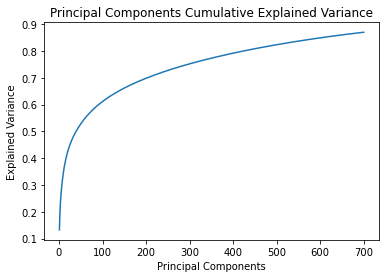

In [52]:
plt.plot(pcs, variance_explained)
plt.title('Principal Components Cumulative Explained Variance')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance')
plt.show()

In [53]:
df_train = pd.DataFrame(reduced_features)
df_train = pd.concat([df_train, train.iloc[:, -2:]], axis = 1, ignore_index=False)

In [54]:
df_test = pd.DataFrame(test_pca)
df_test = pd.concat([df_test, val.iloc[:, -2:]], axis = 1, ignore_index=False)

In [55]:
X = df_train.iloc[:, :-2]
y = np.ravel(df_train.iloc[:,-1:])

The features obtained from Resnet50 and PCA are then passes to KNN to obtain the top-N recommendations.

In [56]:
n = 6
neigh = KNeighborsClassifier(n_neighbors=n)
neigh.fit(X,y)

KNeighborsClassifier(n_neighbors=6)

In [57]:
def read_img(image_path):
    image = load_img(image_path,target_size=(256,256,3))
    image = img_to_array(image)
    image = image/255.
    return image

10 random images and their recommended products using KNN.

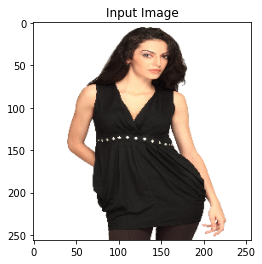

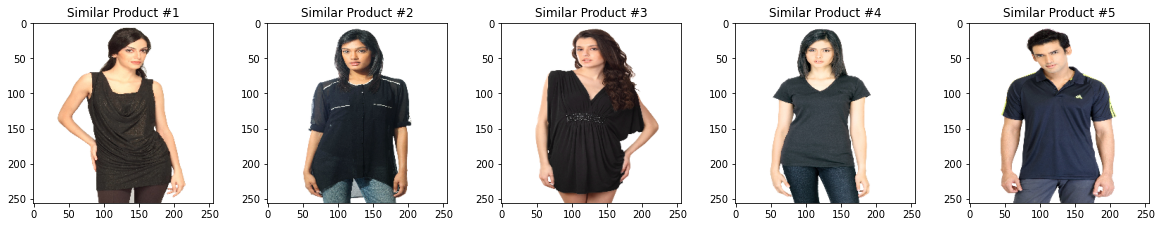

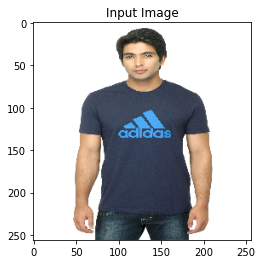

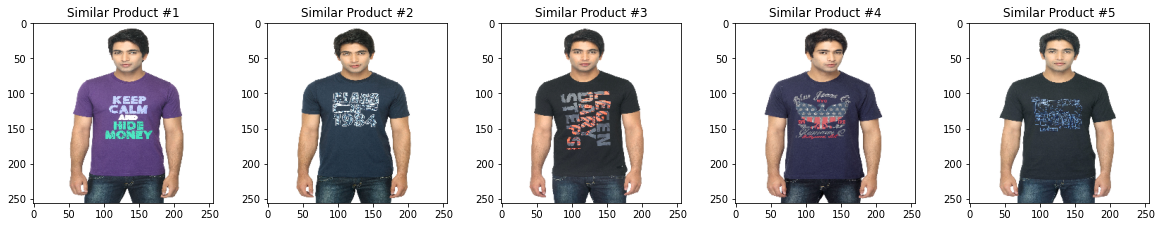

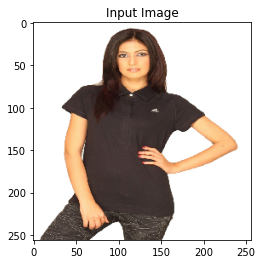

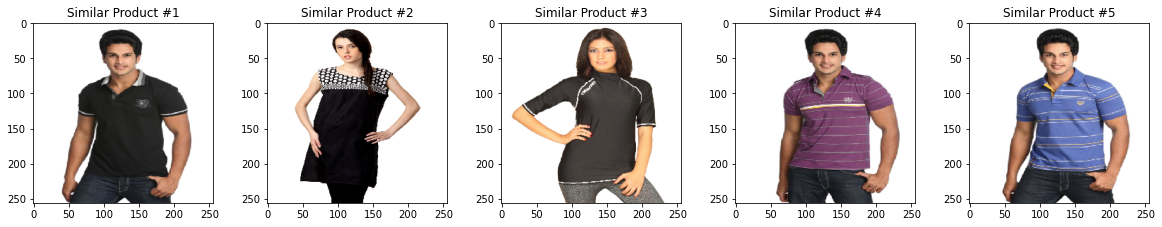

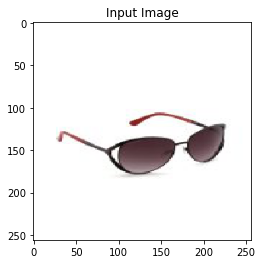

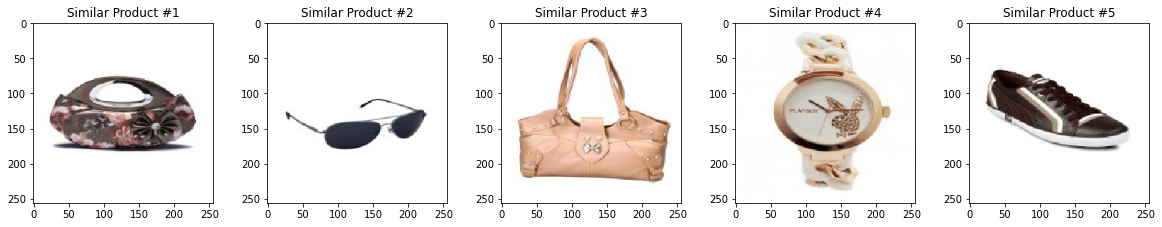

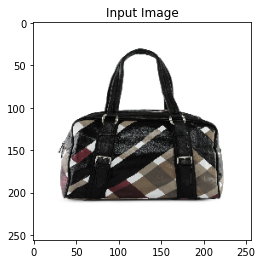

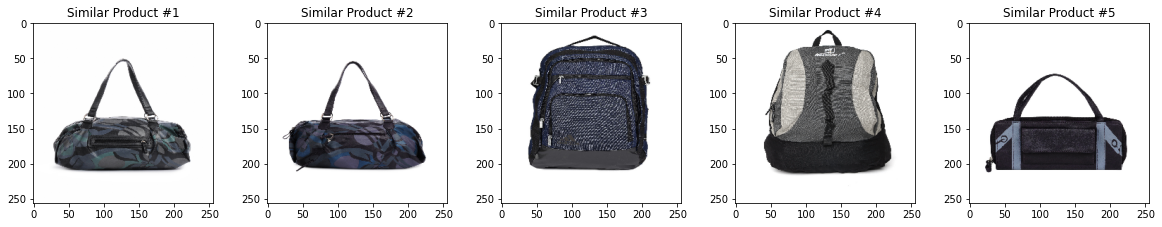

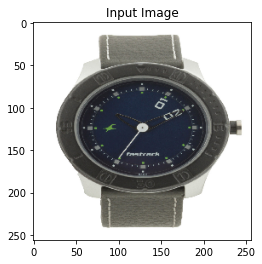

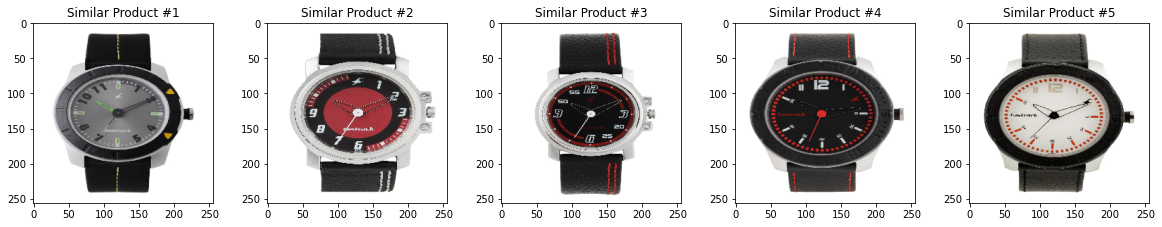

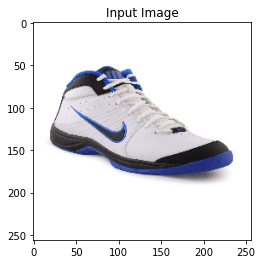

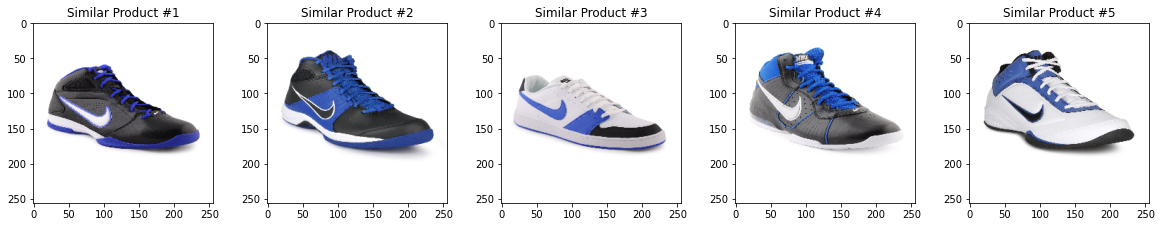

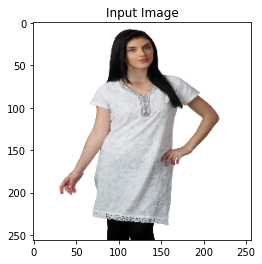

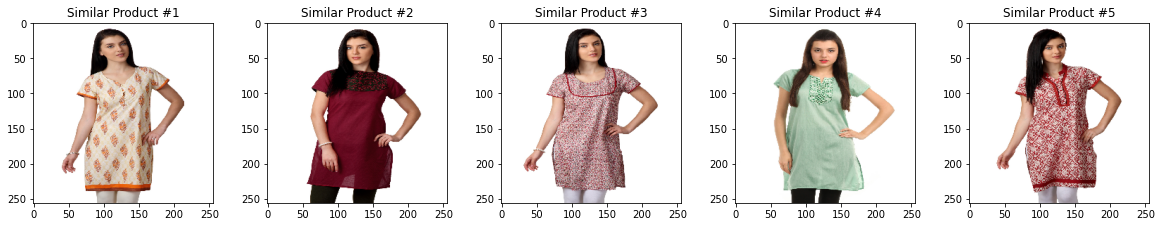

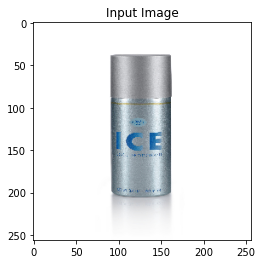

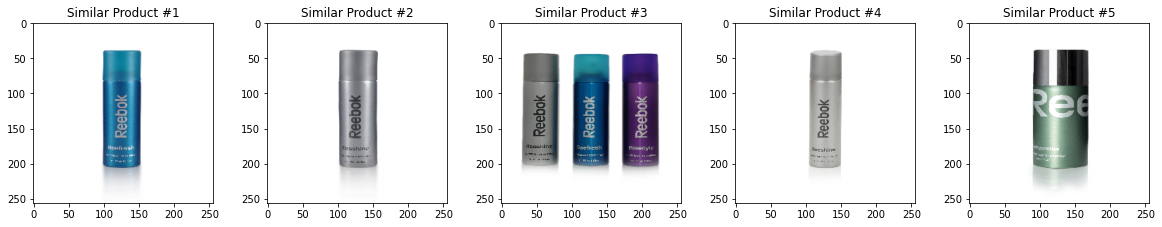

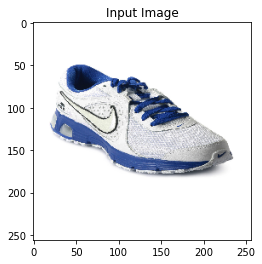

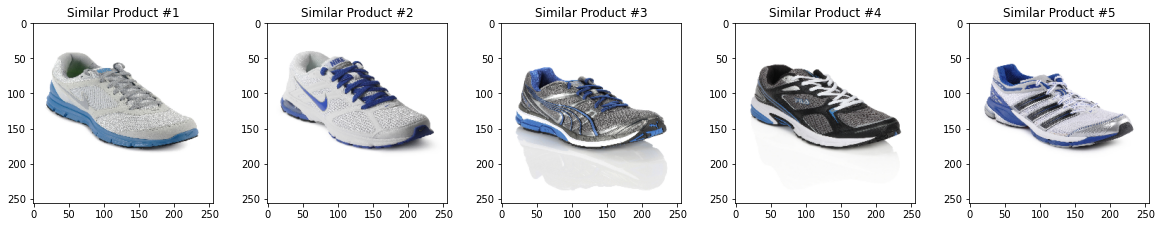

In [58]:
import random
for _ in range(10, 20):
    i = random.randint(1,len(val))
    img1 = read_img(train.loc[i,'filename'])
    dist, index = neigh.kneighbors(X=X.iloc[i,:].values.reshape(1,-1))
    #print(index)
    plt.figure(figsize = (4 , 4))
    plt.imshow(img1)
    plt.title("Input Image")

    plt.figure(figsize = (20 , 20))
    for i in range(1,6):
        plt.subplot(1 , 5, i)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        image = read_img(train.loc[index[0][i],'filename'])
        plt.imshow(image)
        plt.title(f'Similar Product #{i}')


In [59]:
data_img = pd.read_csv("/kaggle/input/fashion-product-images-dataset/fashion-dataset/images.csv")


In [60]:
data_sty = pd.read_csv("/kaggle/input/fashion-product-images-dataset/fashion-dataset/styles.csv", error_bad_lines=False)
data_img['id'] = data_img['filename'].apply(lambda x: x.replace(".jpg","")).astype(int)
data_org = data_sty.merge(data_img,on='id',how='left').reset_index(drop=True)
data_org['filename'] = data_org['filename'].apply(lambda x: os.path.join("../input/fashion-product-images-dataset/fashion-dataset/images/",x))

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

In [61]:
image_files = os.listdir("../input/fashion-product-images-dataset/fashion-dataset/images")
data_org['file_found'] = data_org['id'].apply(lambda x: f"{x}.jpg" in image_files)
data_org = data_org[data_org['file_found']].reset_index(drop=True)

In [62]:
data_org.head(5)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,filename,link,file_found
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,../input/fashion-product-images-dataset/fashio...,http://assets.myntassets.com/v1/images/style/p...,True
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,../input/fashion-product-images-dataset/fashio...,http://assets.myntassets.com/v1/images/style/p...,True
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,../input/fashion-product-images-dataset/fashio...,http://assets.myntassets.com/v1/images/style/p...,True
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,../input/fashion-product-images-dataset/fashio...,http://assets.myntassets.com/v1/images/style/p...,True
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,../input/fashion-product-images-dataset/fashio...,http://assets.myntassets.com/v1/images/style/p...,True


In [63]:
from tensorflow.keras.applications.resnet50 import ResNet50
tfkl = tfk.layers

In [64]:
def build_model(in_shape):
    #build model for embedding
    resnet_base = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape = in_shape)
    resnet_base.trainable = False
    
    model = tfk.Sequential()
    model.add(resnet_base)
    model.add(tfkl.GlobalMaxPooling2D()) #add layer embedding
    print(model.summary())
    return model

In [65]:
in_shape = [2400,1800,3]
model_resnet = build_model(tuple(in_shape))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 75, 57, 2048)      23587712  
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 2048)              0         
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________
None


In [66]:
def get_embedding(image_id, in_shape):
    # Reshape and load image
    img = image.load_img(data['filename'][image_id], target_size=in_shape)
    img = image.img_to_array(img)
    return model_resnet.predict(img.reshape(tuple([1]+in_shape))).reshape(1,-1)

In [67]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
correct_type_knn = 0
in_shape = [2400,1800,3]
for id in range(1,5000):
    if id%100==0:
        print(id,"done!")
    emb = get_embedding(id,in_shape)
    pca_emb = pca.transform(emb)
    #print(pca_emb[0])
    dist, index = neigh.kneighbors(pca_emb[0].reshape(1,-1))
    index = index[0]
    index = index[:-1]
    input_articleType = data_org['articleType'][id]
    for img in index:
        #print(data_org['articleType'][img])
        if (input_articleType == data_org['articleType'][img]):
            #print(data_org['articleType'][img])
            correct_type_knn +=1
accuracy_knn = (correct_type_knn/25000)*100
print(correct_type_knn)
print("Accuray of pca knn for 5000 text images = 43.68")

Accuray of pca knn for 5000 text images = 43.68


--------------------------

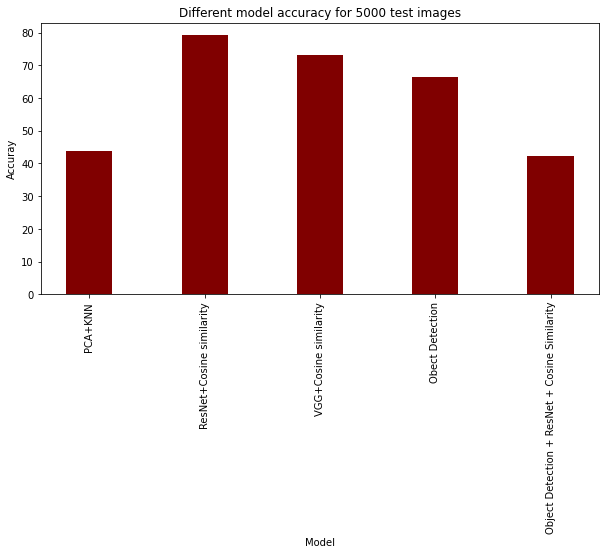

In [4]:
data = {'PCA+KNN':43.68, 'ResNet+Cosine similarity':79.12, 'VGG+Cosine similarity':73.20, 'Obect Detection':66.34,'Object Detection + ResNet + Cosine Similarity': 42.16}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("Model")
plt.ylabel("Accuray")
plt.xticks(rotation = 90)
plt.title("Different model accuracy for 5000 test images")
plt.show()